### Cab-Driver Agent

Approach : Inputting state only as the input to the DL model (Arch 1)

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# # for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
Time_matrix.shape

(5, 5, 24, 7)

In [4]:
Time_matrix[2][1][12][2]

1.0

In [5]:
Time_matrix.shape

(5, 5, 24, 7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


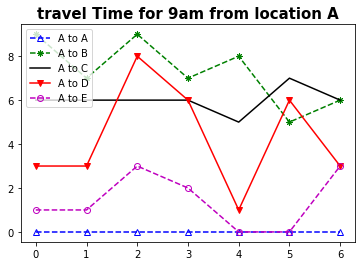

In [6]:
import numpy as np
import matplotlib.pyplot as plt

X_axis = [x for x in range(7)]
t = [Time_matrix[x][0][8] for x in range(0,5)]
 
fig=plt.figure()
plt.title("travel Time for 9am from location A", fontsize=15, fontweight='bold')
ax=fig.add_subplot(111)
 
ax.plot(X_axis,t[0],c='b',marker="^",ls='--',label='A to A',fillstyle='none')
ax.plot(X_axis,t[1],c='g',marker=(8,2,0),ls='--',label='A to B')
ax.plot(X_axis,t[2],c='k',ls='-',label='A to C')
ax.plot(X_axis,t[3],c='r',marker="v",ls='-',label='A to D')
ax.plot(X_axis,t[4],c='m',marker="o",ls='--',label='A to E',fillstyle='none')
# ax.plot(X_axis,x-1,c='k',marker="+",ls=':',label='DGYC')
 
plt.legend(loc=2)
plt.show()

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

REf: https://stackoverflow.com/questions/23582489/python-pickle-protocol-choice

#### Tracking the state-action pairs for checking convergence


In [8]:
import collections
states_track = collections.defaultdict(dict)
def initialise_tracking_states():
    sample_q_values = [((3,0,2),[(3,1),(0,2),(1,4)]),((1,6,3),[(2,3)]),((2,2,2),[(3,2)]),((1,10,6),[(3,4)]),((0,20,3),[(1,4)]),((1,23,3),[(1,4)]),((4,17,1),[(1,2)])]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        for i in q_values[1]:
            action = i
            states_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

Note to self : 
usually, a Python dictionary throws a KeyError if you try to get an item with a key that is not currently in the dictionary. The defaultdict in contrast will simply create any items that you try to access (provided of course they do not exist yet). To create such a "default" item, it calls the function object that you pass to the constructor (more precisely, it's an arbitrary "callable" object, which includes function and type objects). For the first example, default items are created using int(), which will return the integer object 0. For the second example, default items are created using list(), which returns a new empty list object.

In [9]:
initialise_tracking_states() # initialised all the state-action pairs tracked

In [10]:
print(states_track)

defaultdict(<class 'dict'>, {(3, 0, 2): {(3, 1): [], (0, 2): [], (1, 4): []}, (1, 6, 3): {(2, 3): []}, (2, 2, 2): {(3, 2): []}, (1, 10, 6): {(3, 4): []}, (0, 20, 3): {(1, 4): []}, (1, 23, 3): {(1, 4): []}, (4, 17, 1): {(1, 2): []}})


In [11]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_encod_arch(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_list = list(action)
            #print("Action", action_list)
            action_index = env.action_space.index(action_list)
            #print("Action index", action_index)
            Q = prediction[0][action_index]
            #print("Q", Q)
            states_track[state][action].append(Q)          

In [12]:
#Defining a function to save the object as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [13]:
env = CabDriver()

In [14]:
l = env.action_space
print([i for i in enumerate(l)])

[(0, [0, 0]), (1, [0, 1]), (2, [0, 2]), (3, [0, 3]), (4, [0, 4]), (5, [1, 0]), (6, [1, 2]), (7, [1, 3]), (8, [1, 4]), (9, [2, 0]), (10, [2, 1]), (11, [2, 3]), (12, [2, 4]), (13, [3, 0]), (14, [3, 1]), (15, [3, 2]), (16, [3, 4]), (17, [4, 0]), (18, [4, 1]), (19, [4, 2]), (20, [4, 3])]


In [15]:
def build_model(state_size, action_size):
    model = Sequential()
    # Write your code here: Add layers to your neural nets
    model.add(Dense(32,activation='relu',input_dim = state_size, kernel_initializer='he_uniform'))
    model.add(Dense(32,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(action_size,activation='linear', kernel_initializer='he_uniform'))
    
    model.compile(loss='mse',optimizer=Adam(learning_rate=0.001))
    
    model.summary
    
    return model

model1 = build_model(3,21)



In [16]:
state= env.state_init
state

(0, 22, 0)

In [17]:
mini_batch_state = []
mini_batch_state.append(state)

In [18]:
mini_batch_state

[(0, 22, 0)]

In [19]:
# random_list = []
# random_list.append(1)
# for i in range(50):
#     s_p = random_list[i]
#     print(s_p)
#     random_list.append(s_p*2)

# random_list


In [20]:
# mini_batch_state = []
# mini_batch_state.append(state)
SARSnext_Matrix = []
for i in range(50):
    state_prev = mini_batch_state[i]
    possible_actions = env.requests(state_prev)
    print(state_prev, possible_actions)
    action = random.choice(possible_actions[1])
    reward = env.reward_func(state_prev,action,Time_matrix)
    state_next, terminal = env.next_state_func(state_prev, action, Time_matrix)
    SARSnext_Matrix.append((state_prev,action,reward,state_next))
    mini_batch_state.append(state_next)


(0, 22, 0) ([18, 3, 17, 19, 14, 13, 0], [[4, 1], [0, 3], [4, 0], [4, 2], [3, 1], [3, 0], [0, 0]])
(0, 4, 1) ([5, 0], [[1, 0], [0, 0]])
(0, 5, 1) ([12, 18, 16, 4, 0], [[2, 4], [4, 1], [3, 4], [0, 4], [0, 0]])
(0, 6, 1) ([4, 3, 1, 17, 0], [[0, 4], [0, 3], [0, 1], [4, 0], [0, 0]])
(4, 6, 1) ([8, 2, 19, 4, 13, 16, 0], [[1, 4], [0, 2], [4, 2], [0, 4], [3, 0], [3, 4], [0, 0]])
(0, 13, 1) ([11, 0], [[2, 3], [0, 0]])
(3, 16, 1) ([16, 9, 14, 20, 4, 10, 7, 13, 0], [[3, 4], [2, 0], [3, 1], [4, 3], [0, 4], [2, 1], [1, 3], [3, 0], [0, 0]])
(4, 16, 1) ([7, 3, 19, 8, 16, 15, 18, 5, 1, 9, 20, 4, 0], [[1, 3], [0, 3], [4, 2], [1, 4], [3, 4], [3, 2], [4, 1], [1, 0], [0, 1], [2, 0], [4, 3], [0, 4], [0, 0]])
(0, 16, 1) ([0], [[0, 0]])
(0, 17, 1) ([0], [[0, 0]])
(0, 18, 1) ([14, 19, 0], [[3, 1], [4, 2], [0, 0]])
(0, 19, 1) ([5, 9, 19, 16, 11, 4, 0], [[1, 0], [2, 0], [4, 2], [3, 4], [2, 3], [0, 4], [0, 0]])
(0, 21, 1) ([20, 8, 3, 0], [[4, 3], [1, 4], [0, 3], [0, 0]])
(3, 1, 2) ([10, 12, 19, 5, 0], [[2, 1], [

In [21]:
mini_batch_state

[(0, 22, 0),
 (0, 4, 1),
 (0, 5, 1),
 (0, 6, 1),
 (4, 6, 1),
 (0, 13, 1),
 (3, 16, 1),
 (4, 16, 1),
 (0, 16, 1),
 (0, 17, 1),
 (0, 18, 1),
 (0, 19, 1),
 (0, 21, 1),
 (3, 1, 2),
 (0, 6, 2),
 (0, 7, 2),
 (0, 8, 2),
 (1, 14, 2),
 (0, 14, 2),
 (0, 16, 2),
 (3, 22, 2),
 (1, 0, 3),
 (4, 5, 3),
 (3, 7, 3),
 (0, 12, 3),
 (4, 12, 3),
 (4, 12, 3),
 (2, 12, 3),
 (1, 12, 3),
 (1, 16, 3),
 (1, 17, 3),
 (1, 17, 3),
 (2, 21, 3),
 (1, 21, 3),
 (0, 21, 3),
 (0, 22, 3),
 (0, 0, 4),
 (0, 1, 4),
 (0, 2, 4),
 (2, 9, 4),
 (2, 17, 4),
 (4, 1, 5),
 (0, 1, 5),
 (0, 2, 5),
 (4, 6, 5),
 (3, 6, 5),
 (1, 10, 5),
 (2, 14, 5),
 (2, 15, 5),
 (2, 16, 5),
 (2, 17, 5)]

In [22]:
state_encoded_batch = []
for i in mini_batch_state: 
    state_encoded = env.state_encod_arch(i)
    state_encoded_batch.append(state_encoded)

In [23]:
for i in state_encoded_batch:
    print(i)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[

In [24]:
SARSnext_Matrix

[((0, 22, 0), [4, 0], -26.0, (0, 4, 1)),
 ((0, 4, 1), [0, 0], 0.0, (0, 5, 1)),
 ((0, 5, 1), [0, 0], 0.0, (0, 6, 1)),
 ((0, 6, 1), [0, 4], 4.0, (4, 6, 1)),
 ((4, 6, 1), [3, 0], -31.0, (0, 13, 1)),
 ((0, 13, 1), [2, 3], -3.0, (3, 16, 1)),
 ((3, 16, 1), [3, 4], 24.0, (4, 16, 1)),
 ((4, 16, 1), [1, 0], 28.0, (0, 16, 1)),
 ((0, 16, 1), [0, 0], 0.0, (0, 17, 1)),
 ((0, 17, 1), [0, 0], 0.0, (0, 18, 1)),
 ((0, 18, 1), [0, 0], 0.0, (0, 19, 1)),
 ((0, 19, 1), [2, 0], -2.0, (0, 21, 1)),
 ((0, 21, 1), [4, 3], -16.0, (3, 1, 2)),
 ((3, 1, 2), [1, 0], 11.0, (0, 6, 2)),
 ((0, 6, 2), [0, 0], 0.0, (0, 7, 2)),
 ((0, 7, 2), [0, 0], 0.0, (0, 8, 2)),
 ((0, 8, 2), [2, 1], -26.0, (1, 14, 2)),
 ((1, 14, 2), [4, 0], 4.0, (0, 14, 2)),
 ((0, 14, 2), [3, 0], -2.0, (0, 16, 2)),
 ((0, 16, 2), [1, 3], -26.0, (3, 22, 2)),
 ((3, 22, 2), [0, 1], 10.0, (1, 0, 3)),
 ((1, 0, 3), [0, 4], -25.0, (4, 5, 3)),
 ((4, 5, 3), [1, 3], 2.0, (3, 7, 3)),
 ((3, 7, 3), [2, 0], -17.0, (0, 12, 3)),
 ((0, 12, 3), [0, 4], 0.0, (4, 12, 3)),
 

In [25]:
env.action_space

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [1, 0],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 0],
 [2, 1],
 [2, 3],
 [2, 4],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 4],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3]]

In [26]:
y_train= []
for i in mini_batch_state:
    reward_state_i=[]
    for action in env.action_space:
       reward_state_i.append(env.reward_func(i,action,Time_matrix))
    y_train.append(reward_state_i)

In [27]:
for i in y_train: 
    print(i, len(i))
    max_reward_index = np.argmax(i)
    print(max_reward_index)
    print(mini_batch_state[max_reward_index], env.action_space[max_reward_index], i[max_reward_index])
    # print(i.index(max_reward))

[0.0, 8.0, 24.0, 0.0, 24.0, 2.0, 14.0, 14.0, -6.0, -6.0, -6.0, -6.0, -30.0, 0.0, 4.0, 12.0, 20.0, -26.0, -26.0, -30.0, -10.0] 21
2
(0, 5, 1) [0, 2] 24.0
[0.0, 12.0, 24.0, 24.0, 4.0, 13.0, 21.0, -7.0, -7.0, -6.0, 6.0, -10.0, -10.0, -18.0, -22.0, -10.0, -2.0, -1.0, -1.0, -5.0, 15.0] 21
2
(0, 5, 1) [0, 2] 24.0
[0.0, 12.0, 24.0, 24.0, 4.0, 13.0, 21.0, -7.0, -7.0, -6.0, 6.0, -10.0, -10.0, -18.0, -22.0, -10.0, -2.0, -1.0, 3.0, 15.0, 23.0] 21
2
(0, 5, 1) [0, 2] 24.0
[0.0, 28.0, 24.0, 12.0, 4.0, -7.0, -23.0, -27.0, -35.0, -18.0, -18.0, -18.0, -26.0, -3.0, -7.0, 5.0, 13.0, -1.0, 3.0, 15.0, 23.0] 21
1
(0, 4, 1) [0, 1] 28.0
[-5.0, 23.0, 19.0, 7.0, -1.0, 18.0, 26.0, -2.0, -2.0, -1.0, 11.0, -5.0, -5.0, -31.0, -27.0, -23.0, -11.0, 4.0, 8.0, 20.0, 28.0] 21
20
(3, 22, 2) [4, 3] 28.0
[0.0, 28.0, 12.0, 4.0, 4.0, -23.0, 9.0, -27.0, -35.0, -3.0, -3.0, -3.0, -11.0, -1.0, 3.0, 7.0, 19.0, -1.0, -5.0, -1.0, 19.0] 21
1
(0, 4, 1) [0, 1] 28.0
[-5.0, 23.0, 7.0, -1.0, -1.0, 2.0, 34.0, -2.0, -10.0, -7.0, 29.0, 1.0,

#### Instantiating the environment as CabDriver()

In [28]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate =  0.001 
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.001
        self.epsilon_min = 0.00000001
        
        self.batch_size = 200
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32,activation='relu',input_dim= self.state_size, kernel_initializer='he_uniform'))
        model.add(Dense(32,activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size,activation='linear', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(learning_rate =self.learning_rate))
        
        # model.summary
        
        return model

  

    def get_action(self, state, episode):

        # Write your code here:
        possible_actions_index , possible_actions = env.requests(state)
        # get action from model using epsilon-greedy policy
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)  ##Based on the given epsilon-decay example
            
        z = np.random.random()  ##Takes random value [0,1)
        
        if z > epsilon:
            # model.predict(state)
            state_E = env.state_encod_arch(state)
            state_encoded = np.reshape(state_E,(1,self.state_size))
            q_value = self.model.predict(state_encoded)  ###  check shape of predict output
           
            q_values_possible_actions = q_value[0][possible_actions_index] 

            best_action_index = np.argmax(q_values_possible_actions)
            action = possible_actions[best_action_index]
            # best action - from possible actions   
        else:
            #randomly select the actions 
            index_action = np.random.choice(possible_actions_index)
            action = env.action_space[index_action]
        
        return action, epsilon
       
    
    

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        ### [(s,a,r,s'),(s,a,r,s') .... ]
        update_output = np.zeros((self.batch_size,self.state_size))# write here
        update_input = np.zeros((self.batch_size,self.state_size))# write here
        actions, rewards, terminal_states = [], [], []
            
        for i in range(self.batch_size):
            state, action, reward, next_state, terminal_bool  = mini_batch[i]
            # state_next = env.next_state_func(state, action, Time_matrix)
            actions.append(action)
            rewards.append(reward)
            terminal_states.append(terminal_bool)
            # Write your code from here
            # 1.  Update your 'update_output' and 'update_input' batch
            update_input[i] = env.state_encod_arch(state)  ############# Change funcition name to arch at the end no numerical subscript to avoid confusion between state and state-action input ( this code is following state only input) ############
            update_output[i] = env.state_encod_arch(next_state)
        
        target = self.model.predict(update_input)
        q_vals_next_state = self.model.predict(update_output) ## (batchsize,len(action_space))
            
        # Check for terminal state before updating the q-value
        for i in range(self.batch_size):
            action_index = env.action_space.index(actions[i])
            if terminal_states[i]:
                target[i][action_index] = rewards[i]
                
            else:
                target[i][action_index] = rewards[i] + self.discount_factor * (np.amax(q_vals_next_state[i]))
        
        # 4. Fit your model and track the loss values
        self.model.fit(update_input, target, batch_size = self.batch_size, verbose = 1, epochs = 1)
                
             
                
    def load(self, name):
        self.model.load_weights(name)  
     
    def save(self, name):
        self.model.save(name)

numpy.amax

numpy.amax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)
Return the maximum of an array or maximum along an axis.

vs 


numpy.argmax

numpy.argmax
numpy.argmax(a, axis=None, out=None)
Returns the indices of the maximum values along an axis.

### DQN block

agent = DQNagent(...)
for episode in range(Episodes):

    
    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    #Call the DQN agent
    count=0
    while != terminal_state:
        count+=1
        action = agent.get_action(state,episode)
        reward = env.reward_func(state,action,time_matrix)
        next_state,terminal_state = env.next_state_func(state,action,time_matrix)
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        if count%20 == 0:
            # 4. Train the model by calling function agent.train_model
            # 5. Keep a track of rewards, Q-values, loss
            agent.train_model()
    if episode% ==:
        agent.save('')

Call the environment

In [29]:
env = CabDriver()

Call all the initialised variables of the environment

In [30]:
total_time = env.max_time
Total_Episodes = 1000
m =5
t= 24
d= 7

Testing Next_state_func

In [31]:
env.next_state_func((2,5,3),(1,3),Time_matrix)

((3, 12, 3), False)

In [32]:
env.reward_func((2,5,3),(1,3), Time_matrix)

-19.0

Call the DQN agent

In [33]:
action_size = len(env.action_space)
state_size = m+t+d
agent = DQNAgent(state_size = state_size, action_size=action_size)

In [34]:
# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

In [ ]:

Episodes = 1000
for episode in range(0,Episodes):
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    
    while not terminal_state:
        
        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
    if episode % 250 == 0:
        t_stamp = time.strftime("%Y-%m-%d_%H:%M:%S")
        agent.save("./cab_driver{}.h5".format(t_stamp))

    if episode % 25 == 0:   #every 2000th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states()
        save_obj(states_track,'States_tracked')   
        
    
    if episode % 200 == 0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        


episode: 0   score: -315.0   memory length: 143   epsilon: 1.0
1/1 [==============================] - 0s 3ms/step - loss: 36.1727
episode: 25   score: -187.0   memory length: 2000   epsilon: 0.9753099122752334
1/1 [==============================] - 0s 3ms/step - loss: 25.3585


### Tracking Convergence

In [ ]:
# Plotting average rewards
# x-values = 1000 episodes , tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,100000)
epsilon = []
for i in range(0,100000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.00005*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()

In [ ]:
z:0-1
e:0
e>z